In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from fastai.vision.all import *
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

'''import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
'''
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session




/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


"import os\nfor dirname, _, filenames in os.walk('/kaggle/input'):\n    for filename in filenames:\n        print(os.path.join(dirname, filename))\n"

In [2]:
# This is a quick check of whether the notebook is currently running on Google Colaboratory
# or Kaggle, which makes some difference for the code below.
try:
    import google.colab
    colab=True
except:
    colab=False

import os
kaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

In [6]:
# This is copied from Howard's notebook: https://www.kaggle.com/code/jhoward/is-it-a-bird-creating-a-model-from-your-own-data


#NB: Kaggle requires phone verification to use the internet or a GPU. If you haven't done that yet, the cell below will fail
#    This code is only here to check that your internet is enabled. It doesn't do anything else.
#    Here's a help thread on getting your phone number verified: https://www.kaggle.com/product-feedback/135367
import socket,warnings
try:
    socket.setdefaulttimeout(1)
    socket.socket(socket.AF_INET, socket.SOCK_STREAM).connect(('1.1.1.1', 53))
except socket.error as ex: raise Exception("STOP: No internet. Click '>|' in top right and set 'Internet' switch to on")

In [11]:
# Make sure we're using the latest version of fastai
if colab:
    !pip install -Uqq fastbook
    import fastbook
    fastbook.setup_book()

elif kaggle:
    !pip install -Uqq fastai

In [3]:
from pathlib import Path
if colab:
    from google.colab import drive
    drive.mount("/content/gdrive")
    DATA = Path('/content/gdrive/MyDrive/DAT255/')
    DATA.mkdir(exist_ok=True, parents=True)
    
elif kaggle:
    DATA = Path('/kaggle/input/ansikter/full')
    

In [4]:
DATA.ls()

(#8) [Path('/kaggle/input/ansikter/full/surprise'),Path('/kaggle/input/ansikter/full/fear'),Path('/kaggle/input/ansikter/full/neutral'),Path('/kaggle/input/ansikter/full/sadness'),Path('/kaggle/input/ansikter/full/disgust'),Path('/kaggle/input/ansikter/full/contempt'),Path('/kaggle/input/ansikter/full/happiness'),Path('/kaggle/input/ansikter/full/anger')]

In [5]:
get_image_files(DATA)[:5]

(#5) [Path('/kaggle/input/ansikter/full/surprise/S085_003_00000013.png'),Path('/kaggle/input/ansikter/full/surprise/S138_004_00000013.png'),Path('/kaggle/input/ansikter/full/surprise/S068_003_00000014.png'),Path('/kaggle/input/ansikter/full/surprise/m06_dfs_p.JPG'),Path('/kaggle/input/ansikter/full/surprise/f13_dfs_p.JPG')]

In [6]:
ansikt = DataBlock(
    blocks=(ImageBlock, CategoryBlock),             # Define data types for the input and output
    get_items=get_image_files,                      # Function to get image files
    splitter=RandomSplitter(valid_pct=0.2, seed=42),# Split data based on grandparent folder name
    get_y=parent_label,                             # Get labels from parent folder names
    item_tfms=Resize(224),                  # Resize images to 224x224 (options: aug_transforms(224), RandomResizedCrop(460))
    batch_tfms=[
        *aug_transforms(),                          # Apply some data augmentation (see Chapter 2)
        Normalize.from_stats(*imagenet_stats)       # Normalize image intensities (because pretraining)
    ]
)




In [10]:
dls = ansikt.dataloaders(DATA, bs=64)

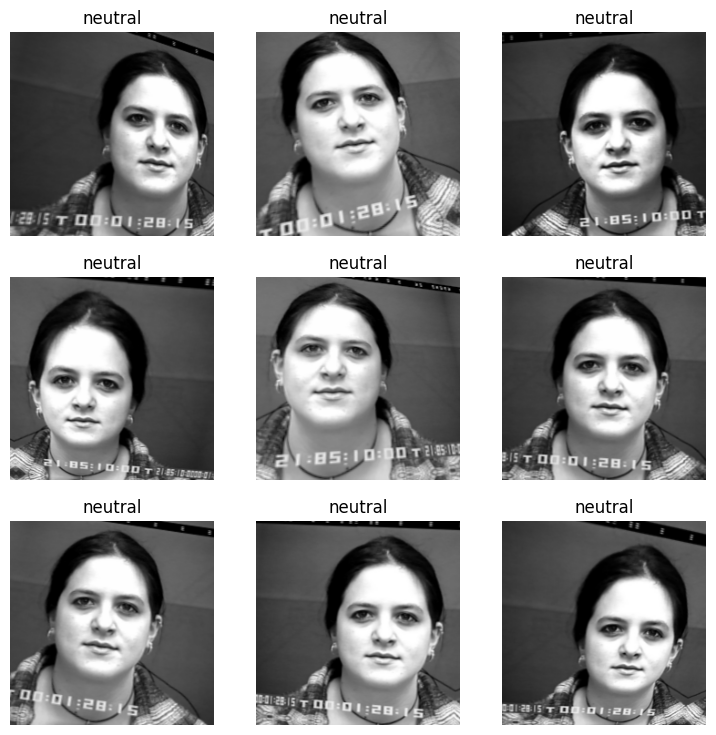

In [11]:
dls.show_batch(unique=True)

In [12]:
learn = vision_learner(dls, resnet34, metrics=accuracy)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 210MB/s] 


In [13]:
learn.fine_tune(5)

epoch,train_loss,valid_loss,accuracy,time
0,2.651899,1.624547,0.563518,00:09


epoch,train_loss,valid_loss,accuracy,time
0,1.475304,1.008968,0.697068,00:09
1,1.140660,0.697669,0.807818,00:10
2,0.866914,0.665551,0.833876,00:10
3,0.687799,0.466162,0.869707,00:10
4,0.559782,0.452759,0.882736,00:10


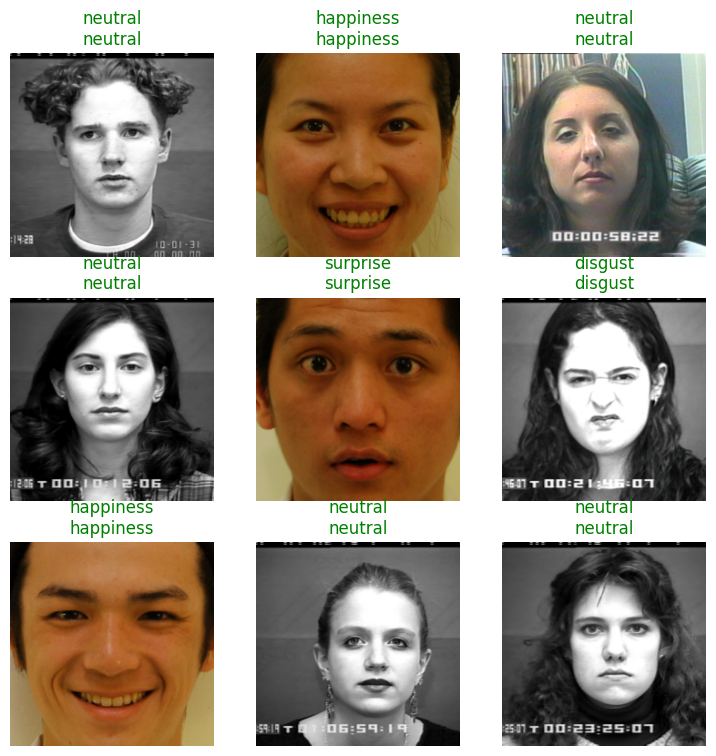

In [14]:
learn.show_results()

In [21]:
#learn.save('my_model')

In [22]:
#learn = load('my_model')


In [23]:
#learn.export('model.pkl')

In [24]:
# laster inn modellen som blir brukt i huggingface..
#learn = torch.load('/kaggle/input/facescan-modell/pytorch/facescan/1/model.pkl')

# Renser dataen

In [67]:
import fastai
from fastai.vision.widgets import ImageClassifierCleaner


In [26]:
from PIL import Image

def _open_thumb(
    fn: Path|str, # A path of an image
    h: int, # Thumbnail Height
    w: int # Thumbnail Width
) -> Image: # `PIL` image to display
    "Opens an image path and returns the thumbnail of the image"
    return Image.open(fn).to_thumb(h, w).convert('RGB') # Changed from RGBA to RGB

In [27]:
# Replace the original function
fastai.vision.widgets._open_thumb = _open_thumb

In [28]:
cleaner = ImageClassifierCleaner(learn, max_n = 25)

In [29]:
cleaner

## Trener modellen på nytt med renset data

In [39]:
dls = ansikt.dataloaders(DATA, bs=64)

In [40]:
learn = vision_learner(dls, resnet18, metrics=error_rate)


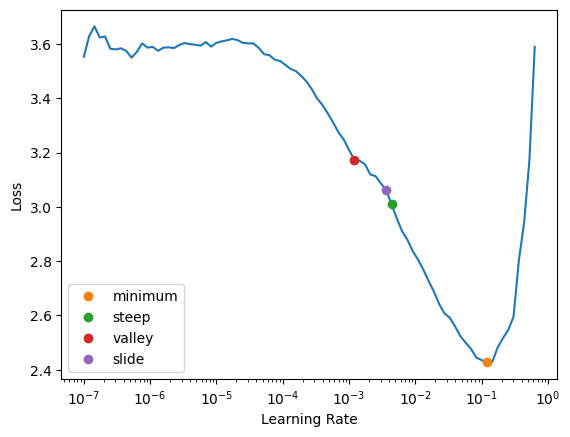

In [41]:
lr = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

In [42]:
learn.fine_tune(5, base_lr=lr.slide)

epoch,train_loss,valid_loss,error_rate,time
0,2.472711,1.261110,0.351792,00:07


epoch,train_loss,valid_loss,error_rate,time
0,1.335392,0.866328,0.296417,00:07
1,1.000311,0.647435,0.172638,00:08
2,0.751237,0.547364,0.172638,00:07
3,0.605996,0.380045,0.123778,00:07
4,0.477830,0.361757,0.100977,00:07


# Modell-evaluering:

In [31]:
interp = ClassificationInterpretation.from_learner(learn)

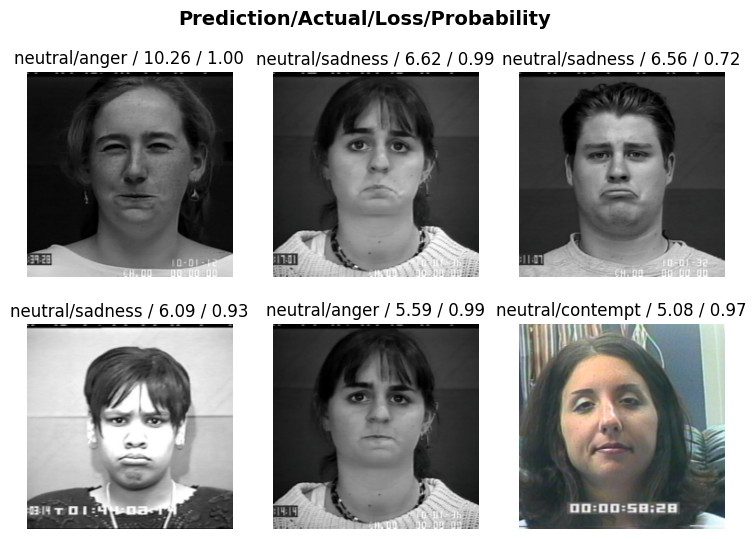

In [32]:
interp.plot_top_losses(6)

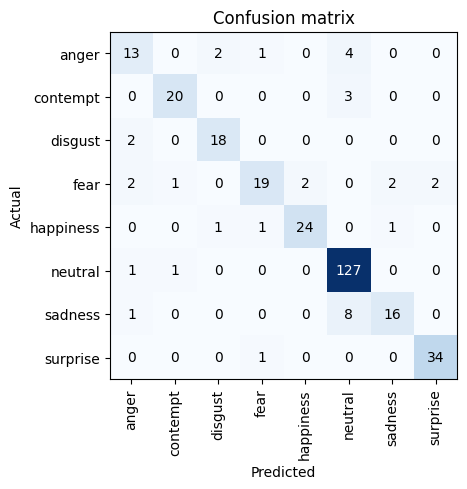

In [33]:
interp.plot_confusion_matrix()

In [34]:
interp.print_classification_report()

              precision    recall  f1-score   support

       anger       0.68      0.65      0.67        20
    contempt       0.91      0.87      0.89        23
     disgust       0.86      0.90      0.88        20
        fear       0.86      0.68      0.76        28
   happiness       0.92      0.89      0.91        27
     neutral       0.89      0.98      0.94       129
     sadness       0.84      0.64      0.73        25
    surprise       0.94      0.97      0.96        35

    accuracy                           0.88       307
   macro avg       0.86      0.82      0.84       307
weighted avg       0.88      0.88      0.88       307



## Aktiveringskart

In [15]:
!pip install -Uqq fastai_amalgam palettable matplotlib_venn



In [19]:
from notebookb4ed0a1743 import *
from fastai.vision import *

In [20]:
val_images = dls.valid.items
val_images[:3]

[Path('/kaggle/input/ansikter/full/neutral/S037_001_00000001.png'),
 Path('/kaggle/input/ansikter/full/neutral/m13_dfh_nx.jpg'),
 Path('/kaggle/input/ansikter/full/neutral/S066_003_00000001.png')]

/opt/conda/lib/python3.10/site-packages/fastai_amalgam/interpret/gradcam.py:65: UserWarning: Detected a pooling layer in the model body. Unless this is intentional, ensure that the feature map is not flattened
  warnings.warn(f"Detected a pooling layer in the model body. Unless this is intentional, ensure that the feature map is not flattened")
/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1344: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/opt/conda/lib/python3.10/site-packages/fastai_amalgam/utils.py:92: UserWarning: Loaded default PIL ImageFont. It's highly recommended you use a custom font as the default font's size cannot be tweaked
  warnings.warn(

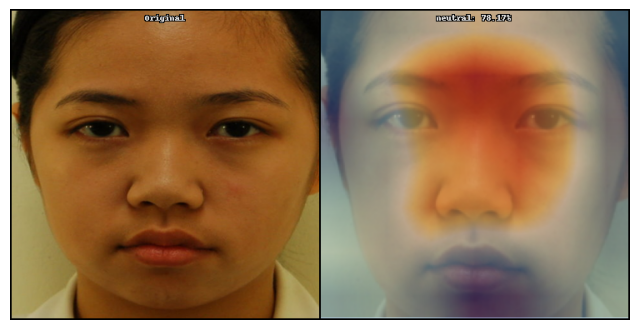

/opt/conda/lib/python3.10/site-packages/fastai_amalgam/interpret/gradcam.py:65: UserWarning: Detected a pooling layer in the model body. Unless this is intentional, ensure that the feature map is not flattened
  warnings.warn(f"Detected a pooling layer in the model body. Unless this is intentional, ensure that the feature map is not flattened")
/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1344: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/opt/conda/lib/python3.10/site-packages/fastai_amalgam/utils.py:92: UserWarning: Loaded default PIL ImageFont. It's highly recommended you use a custom font as the default font's size cannot be tweaked
  warnings.warn(

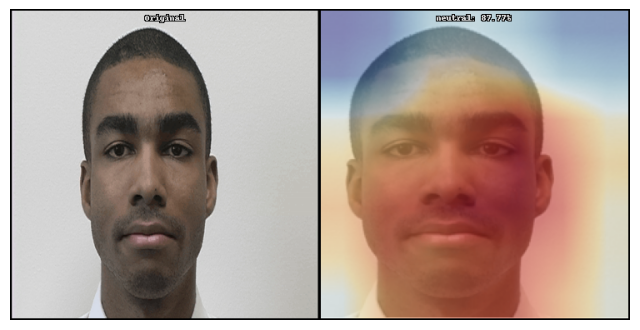

/opt/conda/lib/python3.10/site-packages/fastai_amalgam/interpret/gradcam.py:65: UserWarning: Detected a pooling layer in the model body. Unless this is intentional, ensure that the feature map is not flattened
  warnings.warn(f"Detected a pooling layer in the model body. Unless this is intentional, ensure that the feature map is not flattened")
/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1344: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/opt/conda/lib/python3.10/site-packages/fastai_amalgam/utils.py:92: UserWarning: Loaded default PIL ImageFont. It's highly recommended you use a custom font as the default font's size cannot be tweaked
  warnings.warn(

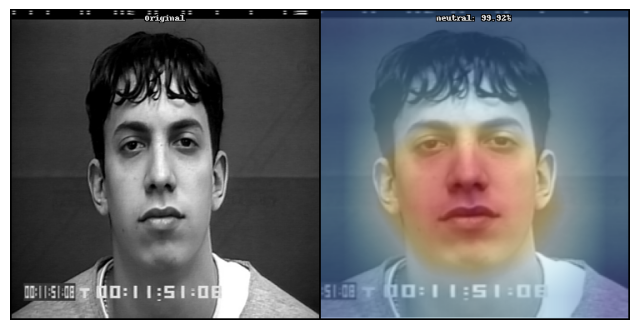

/opt/conda/lib/python3.10/site-packages/fastai_amalgam/interpret/gradcam.py:65: UserWarning: Detected a pooling layer in the model body. Unless this is intentional, ensure that the feature map is not flattened
  warnings.warn(f"Detected a pooling layer in the model body. Unless this is intentional, ensure that the feature map is not flattened")
/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1344: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/opt/conda/lib/python3.10/site-packages/fastai_amalgam/utils.py:92: UserWarning: Loaded default PIL ImageFont. It's highly recommended you use a custom font as the default font's size cannot be tweaked
  warnings.warn(

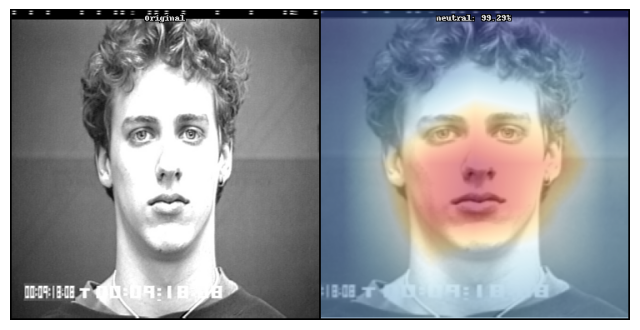

In [22]:
for img_fn in random.choices(val_images, k=4):
    gcam = gradcam(learn, str(DATA/img_fn), show_original=True)
    f = plt.figure(figsize=(8,6))
    plt.imshow(gcam)
    plt.axis('off')
    plt.show()

# Tester på egne bilder

In [ ]:
# Eget bilde
img = PILImage.create('/kaggle/input/ansikter/bilder/img4.jpg')

# Get predictions
pred_class, pred_idx, outputs = learn.predict(img)

# Print results
print(f'Predicted emotion: {pred_class}')
print(f'Predictions index: {pred_idx}')
print(f'Probabilities: {outputs}')

img.show()

Predicted emotion: anger
Predictions index: 0
Probabilities: tensor([8.8514e-01, 1.6275e-02, 1.8709e-02, 6.9079e-04, 4.9697e-03, 6.7978e-02,
        5.3298e-03, 9.1061e-04])


/opt/conda/lib/python3.10/site-packages/fastai_amalgam/interpret/gradcam.py:65: UserWarning: Detected a pooling layer in the model body. Unless this is intentional, ensure that the feature map is not flattened
  warnings.warn(f"Detected a pooling layer in the model body. Unless this is intentional, ensure that the feature map is not flattened")
/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1344: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/opt/conda/lib/python3.10/site-packages/fastai_amalgam/utils.py:92: UserWarning: Loaded default PIL ImageFont. It's highly recommended you use a custom font as the default font's size cannot be tweaked
  warnings.warn(

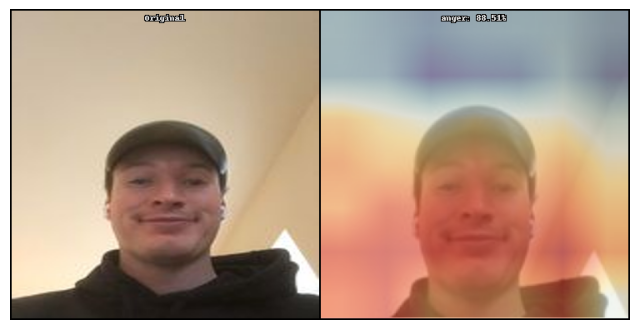

In [25]:
# Eget bilde
img1 = PILImage.create('/kaggle/input/ansikter/bilder/img2.jpg')

# Get predictions (no need to apply after_batch transforms explicitly, predict does that)
pred_class, pred_idx, outputs = learn.predict(img1)

# Print results
print(f'Predicted emotion: {pred_class}')
print(f'Predictions index: {pred_idx}')
print(f'Probabilities: {outputs}')

# Show the image
img1.show()
gcam = gradcam(learn, str(Path('/kaggle/input/ansikter/bilder/img2.jpg')), show_original=True)
f = plt.figure(figsize=(8,6))
plt.imshow(gcam)
plt.axis('off')
plt.show()

Predicted emotion: anger
Predictions index: 0
Probabilities: tensor([0.5089, 0.0263, 0.1282, 0.1155, 0.0024, 0.0065, 0.0846, 0.1276])


/opt/conda/lib/python3.10/site-packages/fastai_amalgam/interpret/gradcam.py:65: UserWarning: Detected a pooling layer in the model body. Unless this is intentional, ensure that the feature map is not flattened
  warnings.warn(f"Detected a pooling layer in the model body. Unless this is intentional, ensure that the feature map is not flattened")
/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1344: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/opt/conda/lib/python3.10/site-packages/fastai_amalgam/utils.py:92: UserWarning: Loaded default PIL ImageFont. It's highly recommended you use a custom font as the default font's size cannot be tweaked
  warnings.warn(

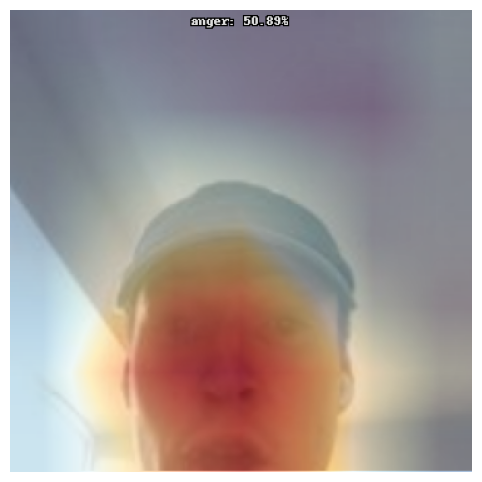

In [28]:
# Eget bilde
img1 = PILImage.create('/kaggle/input/ansikter/bilder/img3.jpg')

# Get predictions (no need to apply after_batch transforms explicitly, predict does that)
pred_class, pred_idx, outputs = learn.predict(img1)

# Print results
print(f'Predicted emotion: {pred_class}')
print(f'Predictions index: {pred_idx}')
print(f'Probabilities: {outputs}')

# Show the image

gcam = gradcam(learn, str(Path('/kaggle/input/ansikter/bilder/img3.jpg')), show_original=True)
f = plt.figure(figsize=(8,6))
plt.imshow(gcam)
plt.axis('off')
plt.show()

Predicted emotion: sadness
Predictions index: 6
Probabilities: tensor([1.5362e-01, 3.7802e-03, 1.5687e-01, 3.0337e-05, 4.4313e-04, 1.5831e-04,
        6.8380e-01, 1.2997e-03])


/opt/conda/lib/python3.10/site-packages/fastai_amalgam/interpret/gradcam.py:65: UserWarning: Detected a pooling layer in the model body. Unless this is intentional, ensure that the feature map is not flattened
  warnings.warn(f"Detected a pooling layer in the model body. Unless this is intentional, ensure that the feature map is not flattened")
/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1344: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/opt/conda/lib/python3.10/site-packages/fastai_amalgam/utils.py:92: UserWarning: Loaded default PIL ImageFont. It's highly recommended you use a custom font as the default font's size cannot be tweaked
  warnings.warn(

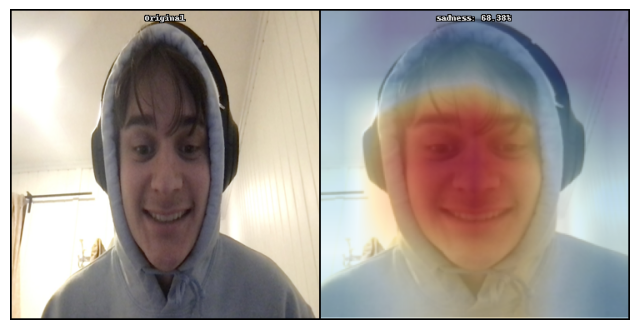

In [29]:
# Eget bilde
img1 = PILImage.create('/kaggle/input/bilder/Photo.jpg')

# Get predictions (no need to apply after_batch transforms explicitly, predict does that)
pred_class, pred_idx, outputs = learn.predict(img1)

# Print results
print(f'Predicted emotion: {pred_class}')
print(f'Predictions index: {pred_idx}')
print(f'Probabilities: {outputs}')

# Show the image
gcam = gradcam(learn, str(Path('/kaggle/input/bilder/Photo.jpg')), show_original=True)
f = plt.figure(figsize=(8,6))
plt.imshow(gcam)
plt.axis('off')
plt.show()

In [ ]:
# Eget bilde
img1 = PILImage.create('/kaggle/input/bilder/Photo2.jpg')

# Get predictions (no need to apply after_batch transforms explicitly, predict does that)
pred_class, pred_idx, outputs = learn.predict(img1)

# Print results
print(f'Predicted emotion: {pred_class}')
print(f'Predictions index: {pred_idx}')
print(f'Probabilities: {outputs}')

# Show the image
img1.show()

Predicted emotion: neutral
Predictions index: 5
Probabilities: tensor([1.4728e-01, 1.7021e-01, 1.6908e-02, 5.0742e-04, 1.7613e-04, 5.5924e-01,
        7.9855e-02, 2.5828e-02])


/opt/conda/lib/python3.10/site-packages/fastai_amalgam/interpret/gradcam.py:65: UserWarning: Detected a pooling layer in the model body. Unless this is intentional, ensure that the feature map is not flattened
  warnings.warn(f"Detected a pooling layer in the model body. Unless this is intentional, ensure that the feature map is not flattened")
/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1344: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/opt/conda/lib/python3.10/site-packages/fastai_amalgam/utils.py:92: UserWarning: Loaded default PIL ImageFont. It's highly recommended you use a custom font as the default font's size cannot be tweaked
  warnings.warn(

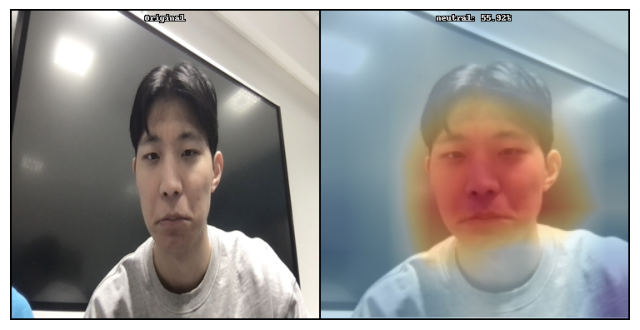

In [35]:
# Eget bilde
img1 = PILImage.create('/kaggle/input/bilder/samuelpic.jpg')

# Get predictions (no need to apply after_batch transforms explicitly, predict does that)
pred_class, pred_idx, outputs = learn.predict(img1)

# Print results
print(f'Predicted emotion: {pred_class}')
print(f'Predictions index: {pred_idx}')
print(f'Probabilities: {outputs}')

# Show the image
gcam = gradcam(learn, str(Path('/kaggle/input/bilder/samuelpic.jpg')), show_original=True)
f = plt.figure(figsize=(8,6))
plt.imshow(gcam)
plt.axis('off')
plt.show()